<center>
    <h1> KAGGLE CASES, Summer 2019 </h1>
    <h1> Project - 1 </h1>
    <h1> Name : Dhivya Swaminathan </h1>
    <h1> UID : 2000434729 </h1>
    <h2> New York Cab Trip Duration Prediction </h2>
<center>

In [2]:
# importing neccesary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from haversine import haversine
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from math import sqrt
from sklearn.linear_model import Lasso
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [4]:
# importing train and test data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [5]:
# function to find trip distance based on pickup and dropoff latitude and longitude using haversine distance
def find_trip_distance(data):
    data['trip_distance'] = data.apply(lambda row: haversine((row['pickup_latitude'], row['pickup_longitude']), 
                                                           (row['dropoff_latitude'], row['dropoff_longitude'])), axis=1)
    data = data.drop(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1)
    return data

train = find_trip_distance(train_data)
test = find_trip_distance(test_data)
print(train.dtypes)
print(test.dtypes)

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
store_and_fwd_flag     object
trip_duration           int64
trip_distance         float64
dtype: object
id                     object
vendor_id               int64
pickup_datetime        object
passenger_count         int64
store_and_fwd_flag     object
trip_distance         float64
dtype: object


In [6]:
# changing to datetime format
dropoff_time_train = train['dropoff_datetime']
train = train.drop(['dropoff_datetime'], axis=1)
train['pickup_datetime'] =  pd.to_datetime(train['pickup_datetime'] , format='%Y-%m-%d %H:%M:%S')
test['pickup_datetime'] =  pd.to_datetime(test['pickup_datetime'] , format='%Y-%m-%d %H:%M:%S')

print(train.dtypes)
print(test.dtypes)

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
store_and_fwd_flag            object
trip_duration                  int64
trip_distance                float64
dtype: object
id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
store_and_fwd_flag            object
trip_distance                float64
dtype: object


In [7]:
# function to get time related features of the pickup time
def get_day_of_week(data):
    data['hour_of_pickup'] = pd.Series([int(date.strftime('%H')) for date in data['pickup_datetime']])
    data['minute_of_pickup'] = pd.Series([int(date.strftime('%M')) for date in data['pickup_datetime']])
    data['day_of_month'] = pd.Series([int(date.strftime('%d')) for date in data['pickup_datetime']])
    data['month'] = pd.Series([int(date.strftime('%m')) for date in data['pickup_datetime']])
    data['day_of_week'] = pd.Series([int(date.weekday()) for date in data['pickup_datetime']])
    data = data.drop(['pickup_datetime'], axis=1)
    return data

train = get_day_of_week(train)
test = get_day_of_week(test)

print(test.dtypes)

id                     object
vendor_id               int64
passenger_count         int64
store_and_fwd_flag     object
trip_distance         float64
hour_of_pickup          int64
minute_of_pickup        int64
day_of_month            int64
month                   int64
day_of_week             int64
dtype: object


In [8]:
X = train.loc[:,['passenger_count', 'trip_distance', 'hour_of_pickup', 'minute_of_pickup','day_of_week','day_of_month','month']]
y = train.loc[:,'trip_duration']
Xtrain, Xtest, ytrain, ytest = sk.model_selection.train_test_split(X, y, test_size=0.20, random_state=42)

In [9]:
# method to find rmsle of a model and define a rmsle scorer for optimising parameters using GridSearchCV
def rmsle(y_true, y_pred):
    return sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

### Linear Regression

In [8]:
lr = LinearRegression()
lr.fit(Xtrain, ytrain)
print("Training Error : ", rmsle(ytrain, lr.predict(Xtrain)))
print("Testing Error : ", rmsle(ytest, lr.predict(Xtest)))

Training Error :  0.6867840778033466
Testing Error :  0.6870581088242522


### Random Forest Regressor

In [9]:
rf = RandomForestRegressor()
rf.fit(Xtrain, ytrain)
print("Training Error : ", rmsle(ytrain, rf.predict(Xtrain)))
print("Testing Error : ", rmsle(ytest, rf.predict(Xtest)))

Training Error :  0.3327485656711632
Testing Error :  0.621894322108409


### Gradient Boosting Regressor

In [10]:
gb = GradientBoostingRegressor()
gb.fit(Xtrain, ytrain)
print("Training Error : ", rmsle(ytrain, gb.predict(Xtrain)))
test_predictions = gb.predict(Xtest)
test_predictions[test_predictions < 0] = 0
print("Testing Error : ", rmsle(ytest, test_predictions))

Training Error :  0.5718404414887566
Testing Error :  0.5741350288747183


### XGB Regressor

In [10]:
xgb = XGBRegressor()
xgb.fit(Xtrain, ytrain)
print("Training Error : ", rmsle(ytrain, xgb.predict(Xtrain)))
test_predictions = xgb.predict(Xtest)
test_predictions[test_predictions < 0] = 0
print("Testing Error : ", rmsle(ytest, test_predictions))

Training Error :  0.5723136459828121
Testing Error :  0.5743113641066209


## Feature Engineering

### creating pickup and drop off cluster

In [11]:
coords = np.vstack((train_data[['pickup_latitude', 'pickup_longitude']].values,
                    train_data[['dropoff_latitude', 'dropoff_longitude']].values,
                    test_data[['pickup_latitude', 'pickup_longitude']].values,
                    test_data[['dropoff_latitude', 'dropoff_longitude']].values))
sample_ind = np.random.permutation(len(coords))[:250000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=8000).fit(coords[sample_ind])

In [12]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train_data[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train_data[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test_data[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test_data[['dropoff_latitude', 'dropoff_longitude']])

In [13]:
train.dtypes

id                     object
vendor_id               int64
passenger_count         int64
store_and_fwd_flag     object
trip_duration           int64
trip_distance         float64
hour_of_pickup          int64
minute_of_pickup        int64
day_of_month            int64
month                   int64
day_of_week             int64
pickup_cluster          int32
dropoff_cluster         int32
dtype: object

In [14]:
test.dtypes

id                     object
vendor_id               int64
passenger_count         int64
store_and_fwd_flag     object
trip_distance         float64
hour_of_pickup          int64
minute_of_pickup        int64
day_of_month            int64
month                   int64
day_of_week             int64
pickup_cluster          int32
dropoff_cluster         int32
dtype: object

### Finding the correlation between the features

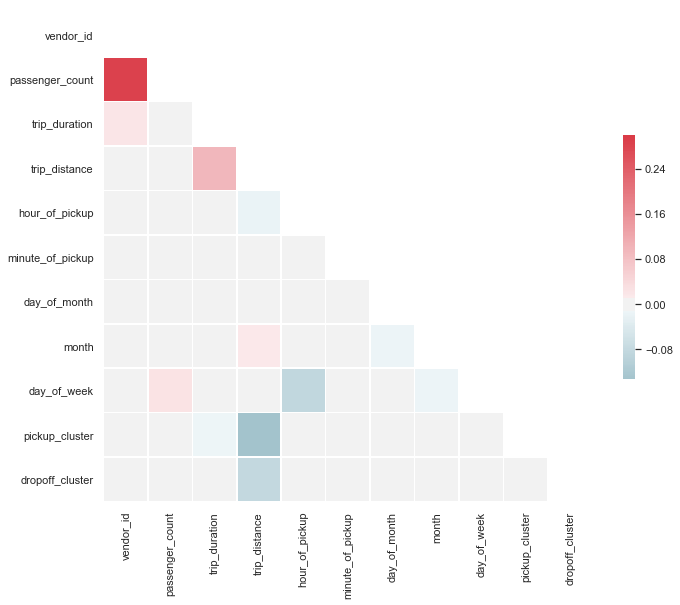

In [15]:
import seaborn as sns
# Correlation plot using seaborn
from string import ascii_letters

sns.set(style="white")

# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [16]:
# Splitting data into train and test
X = train.loc[:,['passenger_count', 'trip_distance', 'hour_of_pickup', 'minute_of_pickup','day_of_week','day_of_month','month']]
y = train.loc[:,'trip_duration']
Xtrain, Xtest, ytrain, ytest = sk.model_selection.train_test_split(X, y, test_size=0.20, random_state=42)

In [17]:
# building a gradient boosting regressor again to check if the new features are good
gb = GradientBoostingRegressor()
gb.fit(Xtrain, ytrain)
train_predictions = gb.predict(Xtrain)
train_predictions[train_predictions < 0] = 0
print("Training Error : ", rmsle(ytrain, train_predictions))
test_predictions = gb.predict(Xtest)
test_predictions[test_predictions < 0] = 0
print("Testing Error : ", rmsle(ytest, test_predictions))

Training Error :  0.5718404414887546
Testing Error :  0.5741155292084775


In [18]:
# building an XGB regressor model
xgb = XGBRegressor()
xgb.fit(Xtrain, ytrain)
train_predictions = xgb.predict(Xtrain)
train_predictions[train_predictions < 0] = 0
print("Training Error : ", rmsle(ytrain, train_predictions))
test_predictions = xgb.predict(Xtest)
test_predictions[test_predictions < 0] = 0
print("Testing Error : ", rmsle(ytest, test_predictions))

Training Error :  0.5723136459828121
Testing Error :  0.5743113641066209


### Predicting the test set

In [20]:
dtest = test.loc[:,['passenger_count', 'trip_distance', 'hour_of_pickup', 'minute_of_pickup','day_of_week','day_of_month','month']]
ytest = xgb.predict(dtest)
test['trip_duration'] = ytest
test[['id', 'trip_duration']].to_csv('xgb_submission.csv', index=False)